In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import os
import zipfile

In [5]:
!pip install kaggle
# Upload your Kaggle API credentials JSON file
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset from Kaggle
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

Saving archive.zip to archive.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
License(s): ODbL-1.0
100% 119M/119M [00:04<00:00, 33.5MB/s]
100% 119M/119M [00:04<00:00, 27.8MB/s]


In [6]:
with zipfile.ZipFile("chest-ctscan-images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/chest-ctscan-images")

In [7]:
import numpy as np
import cv2
import os
from sklearn.utils import shuffle
import tensorflow as tf
def load_dataset(dataset_folder_path, label_to_int=None):
    data = []
    labels = []
#If the label_to_int dictionary is not provided, the function initializes an
#empty dictionary label_to_int and sets int_label to 0.
#This allows the function to automatically map labels to unique integer values.
    if label_to_int is None:
        label_to_int = {}  # Dictionary to map labels to integers
        int_label = 0
 #f the label_to_int dictionary is provided, the function sets int_label to the next available integer
#value after the maximum integer label in the dictionary.
#This ensures that new labels are mapped to unique integer values.
    else:
        int_label = max(label_to_int.values()) + 1

    for folder_name in os.listdir(dataset_folder_path):
        if folder_name not in label_to_int:
            label_to_int[folder_name] = int_label
            int_label += 1

        folder_path = os.path.join(dataset_folder_path, folder_name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (32, 32))  # Adjust the dimensions as needed
            data.append(image)
            labels.append(folder_name)

    # Convert the lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, label_to_int
# Load the test dataset,holds the path to the folder containing the test data.
test_dataset_path = "/content/chest-ctscan-images/Data/test/"
test_data, test_labels, label_to_int = load_dataset(test_dataset_path)

# Load the train dataset , loads the test data and corresponding labels
# into test_data and test_labels, respectively.
# It also returns the updated label_to_int dictionary
train_dataset_path = "/content/chest-ctscan-images/Data/train/"
train_data, train_labels, label_to_int = load_dataset(train_dataset_path, label_to_int)

# Load the validation dataset
valid_dataset_path = "/content/chest-ctscan-images/Data/valid/"
valid_data, valid_labels, label_to_int = load_dataset(valid_dataset_path, label_to_int)

# Shuffle the datasets, Shuffling the datasets is important to introduce randomness
# and prevent the model from learning the order of the data, which could lead to biased learning.
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)
valid_data, valid_labels = shuffle(valid_data, valid_labels, random_state=42)

# Normalize the pixel values to [0, 1] , To make the data suitable for training neural networks,
# it is essential to normalize these pixel values to a range of [0, 1].
#This is achieved by dividing all pixel values by 255
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0
valid_data = valid_data.astype('float32') / 255.0

# Convert the labels to integers using label_to_int dictionary ,
# This is necessary because neural networks require the target values (labels)
# to be represented as integers rather than strings.
train_labels = np.array([label_to_int[label] for label in train_labels])
test_labels = np.array([label_to_int[label] for label in test_labels])
valid_labels = np.array([label_to_int[label] for label in valid_labels])

# Convert the labels to one-hot encoded vectors,
#Each label vector will have a length equal to the number of classes,
#and the element corresponding to the class will be set to 1.
num_classes = len(label_to_int)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels, num_classes)

width and height of 32 pixels each and three color channels (RGB).sequential model, which is a linear stack of layers where each layer has exactly one input tensor and one output tensor.2D convolutional layer has 6 filters(kernels).ReLU(Rectified Linear Unit),which introduces non-linearity to the model.Max pooling reduces the spatial dimensions of the data and helps in extracting the most important features by selecting the maximum value.,applied after the first layer.flattens the 2D output of the previous layer into a 1D vector. This is necessary because the next layers in the model are fully connected (dense)layers, which require a 1D input.The activation function used here is softmax, which converts the raw scores into probabilities, indicating the likelihood of each class.

In [8]:
input_shape = (32, 32, 3)  # Adjust the dimensions as per your dataset

model = tf.keras.Sequential()
model.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

the model will update its weights after processing 32 samples in each batch.epoch,how many times the entire training dataset will be passed through the network during training

In [9]:
batch_size = 32
epochs = 10
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

Epoch 1/10
20/20 [==============================] - 4s 28ms/step - loss: 1.5413 - accuracy: 0.2545 - val_loss: 5.1947 - val_accuracy: 0.1714
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 1.2662 - accuracy: 0.4095 - val_loss: 5.7293 - val_accuracy: 0.0508
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 1.2167 - accuracy: 0.4225 - val_loss: 5.4906 - val_accuracy: 0.1302
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 1.1281 - accuracy: 0.4519 - val_loss: 6.2344 - val_accuracy: 0.1714
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 1.1151 - accuracy: 0.4812 - val_loss: 4.9190 - val_accuracy: 0.1175
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 1.0471 - accuracy: 0.5188 - val_loss: 6.3577 - val_accuracy: 0.1556
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.9694 - accuracy: 0.5612 - val_loss: 5.9572 - val_accuracy: 0.1714
Epoch 8/10
20/20 [=

In [10]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

10/10 [==============================] - 0s 3ms/step - loss: 8.3163 - accuracy: 0.1302
Test Loss: 8.316349983215332
Test Accuracy: 0.13015873730182648


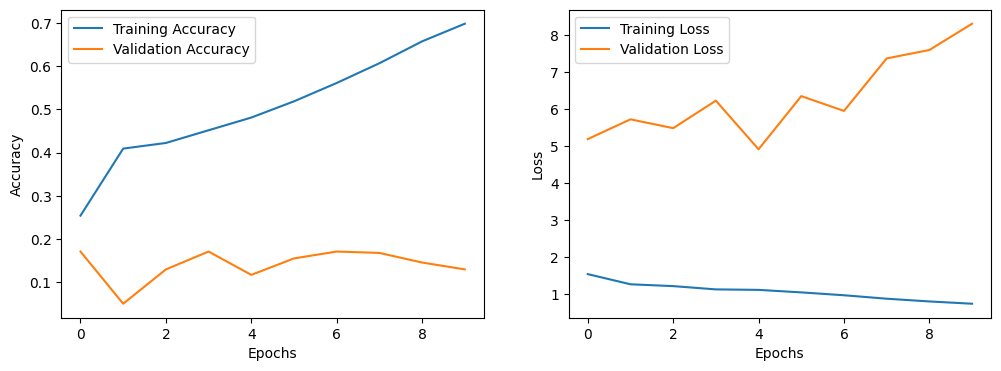

In [11]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Plot the training history
plot_history(history)

In [12]:
from sklearn.metrics import confusion_matrix
# Assuming you have already trained your model and obtained predictions on the test set
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)
# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

10/10 [==============================] - 0s 2ms/step
Confusion Matrix:
[[ 0  0  0  9 35 14 32]
 [ 0  0  0  5 27 17  2]
 [ 0  0  0 12 45 29 34]
 [ 0  0  0 41 13  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


In [13]:
from sklearn.metrics import accuracy_score
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Compute the accuracy
accuracy = accuracy_score(np.argmax(test_labels, axis=1), predicted_labels)
# Display the accuracy percentage
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 13.02%


In [14]:
from sklearn.metrics import classification_report
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Compute the classification report
report = classification_report(np.argmax(test_labels, axis=1), predicted_labels)
# Display the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00       120
           3       0.61      0.76      0.68        54
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.13       315
   macro avg       0.09      0.11      0.10       315
weighted avg       0.10      0.13      0.12       315



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
f1 = f1_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Precision: 0.10
Recall: 0.13
F1-Score: 0.12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


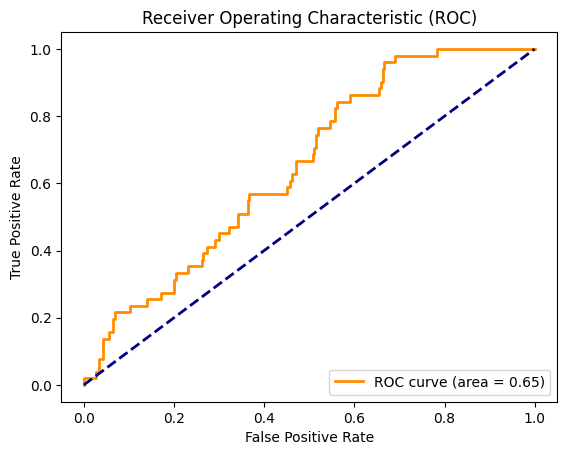

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Assuming binary classification (two classes) for simplicity
# If your problem is multi-class, you need to modify the code accordingly
fpr, tpr, thresholds = roc_curve(test_labels[:, 1], predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

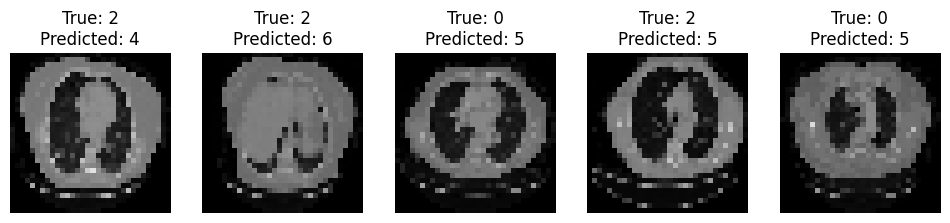

In [17]:
import random
# Assuming you have already trained your model and obtained predictions on the test set
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)
# Choose a random subset of test data and corresponding true and predicted labels
# visualizing a random subset of test data along with their true and predicted labels
# after making predictions using a trained model
random_indices = random.sample(range(len(test_data)), 5)
sample_images = test_data[random_indices]
sample_true_labels = np.argmax(test_labels[random_indices], axis=1)
sample_predicted_labels = predicted_labels[random_indices]
# Visualize the sample images with true and predicted labels
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_true_labels[i]}\nPredicted: {sample_predicted_labels[i]}")
    plt.axis('off')
plt.show() #displays the entire figure with the sample images and their corresponding labels.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

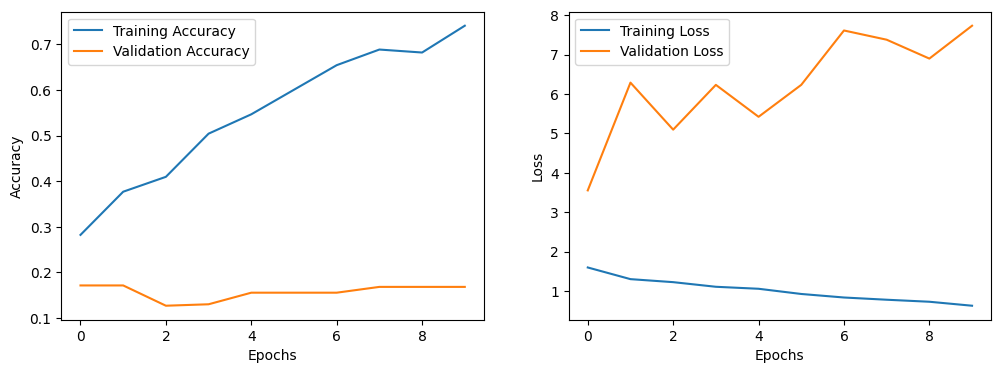

Epoch 1/5
20/20 [==============================] - 1s 15ms/step - loss: 0.5252 - accuracy: 0.8108 - val_loss: 8.0290 - val_accuracy: 0.1683
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.5050 - accuracy: 0.8157 - val_loss: 8.4090 - val_accuracy: 0.1683
Epoch 3/5
20/20 [==============================] - 0s 6ms/step - loss: 0.4947 - accuracy: 0.8303 - val_loss: 8.8302 - val_accuracy: 0.1683
Epoch 4/5
20/20 [==============================] - 0s 9ms/step - loss: 0.4827 - accuracy: 0.8320 - val_loss: 8.9251 - val_accuracy: 0.1683
Epoch 5/5
10/10 [==============================] - 0s 3ms/step - loss: 9.3248 - accuracy: 0.1683


<ipython-input-18-01358417d294>:74: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, model_save_path)


Fine-tuned Model Test Loss: 9.324841499328613
Fine-tuned Model Test Accuracy: 0.16825397312641144


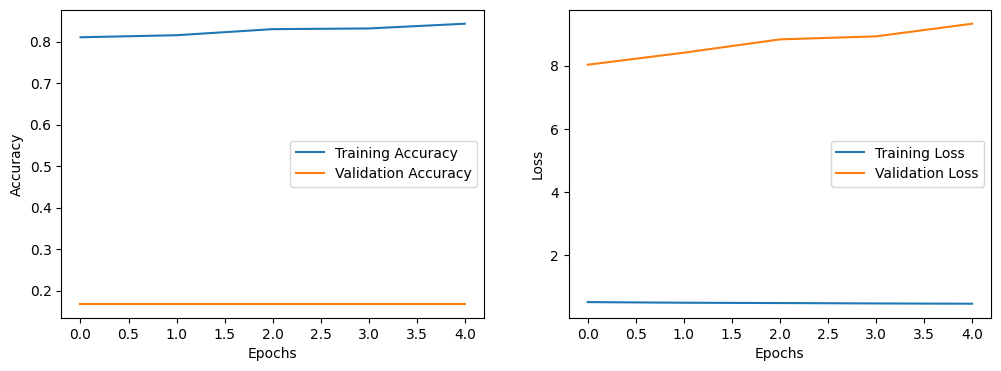

In [18]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import os
import zipfile
# Rest of the code for dataset loading...
# Calculate the number of classes
num_classes = len(label_to_int)
# LeNet model architecture
input_shape = (32, 32, 3)  # Adjust the dimensions as per your dataset
model = tf.keras.Sequential()
model.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Training the LeNet model
batch_size = 32
epochs = 10
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
# Function to plot the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Plot the training history for LeNet model
plot_history(history)
# Fine-tuning the LeNet model

# Step 1: Unfreeze the last few layers of the LeNet model
# By default, all layers are trainable. We'll set the last few layers to be trainable for fine-tuning.
num_layers_to_freeze = 6  # You can adjust this based on your preference
for layer in model.layers[:-num_layers_to_freeze]:
    layer.trainable = False

# Step 2: Compile the model with a lower learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Fine-tune the model with your training data
fine_tune_epochs = 5  # You can adjust the number of fine-tuning epochs based on your preference
fine_tune_history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=fine_tune_epochs, validation_data=(test_data, test_labels))
from tensorflow.keras.models import save_model
model_save_path = "lenet_model.h5"
save_model(model, model_save_path)
# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size)
print('Fine-tuned Model Test Loss:', test_loss)
print('Fine-tuned Model Test Accuracy:', test_accuracy)

# Plot the fine-tuned model training history
plot_history(fine_tune_history)

In [27]:
!pip install tensorflow

Please upload a CT scan image:


Saving image eg 1.png to image eg 1 (3).png
1/1 [==============================] - 1s 614ms/step


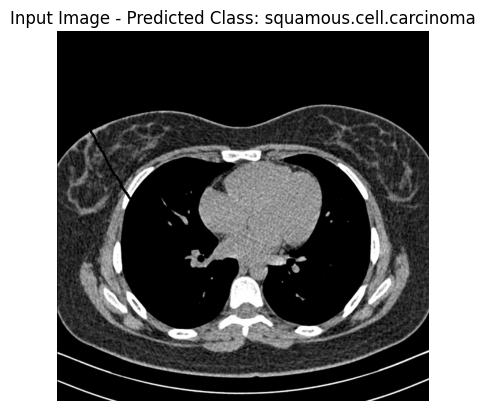

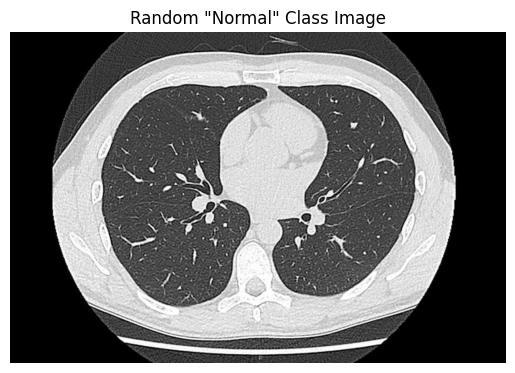

In [28]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from google.colab import files

# Define the label_to_int dictionary to map class labels to integers
label_to_int = {
    "adenocarcinoma": 0,
    "large Cell carcinoma": 1,
    "normal": 2,
    "squamous.cell.carcinoma": 3
}

# Function to preprocess the input image
def preprocess_input_image(image_path, input_shape):
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB mode
    image = image.resize(input_shape)
    image = img_to_array(image)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Load the fine-tuned LeNet model
model_path = "lenet_model.h5"  # Replace with the actual path of your LeNet model
fine_tuned_model = load_model(model_path)

# Ask the user to upload a CT scan image
print("Please upload a CT scan image:")
uploaded_files = files.upload()

# Get the file path of the uploaded image
input_image_path = list(uploaded_files.keys())[0]

# Preprocess the input image
input_shape = (32, 32)  # LeNet model input dimensions
input_image = preprocess_input_image(input_image_path, input_shape)

# Use the fine-tuned LeNet model to predict the class of the input image
predictions = fine_tuned_model.predict(input_image)

# Get the predicted class label based on label_to_int dictionary
predicted_label = list(label_to_int.keys())[np.argmax(predictions)]

# Load and display the input image
input_image = Image.open(input_image_path)
plt.imshow(input_image)
plt.title(f'Input Image - Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()

# Load and display a random "normal" class image
normal_images_path = "/content/chest-ctscan-images/Data/valid/normal/"  # Replace with the path to the directory containing "normal" class images
normal_images = os.listdir(normal_images_path)
random_normal_image = random.choice(normal_images)

# Load and display the random "normal" image
output_image_path = os.path.join(normal_images_path, random_normal_image)
output_image = Image.open(output_image_path)
plt.imshow(output_image)
plt.title('Random "Normal" Class Image')
plt.axis('off')
plt.show()
